<a href="https://colab.research.google.com/github/mitesh98/LSTM-Deep-Learning/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Reading Data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import re
from bs4 import BeautifulSoup
from collections import Counter
from collections import OrderedDict 
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

In [0]:
con=sqlite3.connect("database.sqlite")
filtered_data=pd.read_sql_query("SELECT * FROM `Reviews` WHERE `Score` !=3",con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
def partition(x):
    if x < 3:
        return 0
    return 1

In [0]:
actual_score=filtered_data['Score']
posnegative=actual_score.map(partition)
filtered_data['Score']=posnegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
df=filtered_data.sample(5000)


In [0]:
df.shape

(5000, 10)

In [0]:
#Deduplication of entries
final=df.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(4944, 10)

In [0]:
final=final[['Text','Score']]
final.head()

,Text,Score
146032,"Received this in good time, personally haven't...",1
480881,"I had just taken a Freshly made Spinach, Feta,...",1
475985,My Dogs love this food..This food is so much c...,1
126825,very good buy (the subscribe & save really mad...,1
197612,What a waste of money!!!!!! Based on other cus...,0


# 2. Data Cleaning
** 2.1 Hyperlink Removal**

In [0]:
for i in range(0,4944):
  final['Text'].values[i] = re.sub(r"http\S+", "", final['Text'].values[i])

**2.2 html tags Removal**

In [0]:
#Remove HTML tags
for i in range(1,4944):
  soup = BeautifulSoup(final['Text'].values[i],'lxml')
  text = soup.get_text()
  final['Text'].values[i]=text

# LSTM

# 3.1 Training Data Preparation

In [0]:
y=list(final['Score'])
reviews=list(final['Text']) #x
len(y)

4944

In [0]:
list_of_word=[]
for review in reviews:
  words=review.split()
  for word in words:
    list_of_word.append(word)

In [0]:
counts = Counter(list_of_word)
list_of_unique_word=list(counts.elements())
print("Total No of unique words :",len(list_of_unique_word))

Total No of unique words : 379914


In [0]:
#No of top words we have to take=5000
no_of_top_words=5000
top=counts.most_common(no_of_top_words)
top_words=[]
for word in top:
  top_words.append(word[0])
print("Top words\tFrequency")
for i in range(0,10):
  print(top[i][0],"\t\t",top[i][1])

Top words	Frequency
the 		 13758
I 		 11695
and 		 10603
a 		 9894
to 		 8366
of 		 6613
is 		 6199
it 		 5386
in 		 4420
for 		 4294


In [0]:
x_list=[]
i=0
for review in reviews:
  index_list=[]
  for word in review.split():
    try:
      if word in top_words:
        index_list.append(top_words.index(word))
    except:
      print(word,": Not found")
  x_list.append(index_list)
  i+=1

**Splitting into train and test**

In [0]:
y_train=y[0:3958]
x_train=x_list[0:3958]
y_test=y[3958:]
x_test=x_list[3958:]

In [0]:
print("training size of x= {} y= {}".format(len(y_train),len(x_train)))
print("test size of x= {} y= {}" .format(len(y_test) ,len(x_test)))

training size of x= 3958 y= 3958
test size of x= 986 y= 986


In [0]:
print(x_train[1])
print(type(x_train[1]))
print(len(x_train[1]))

[1, 43, 33, 1313, 3, 118, 2385, 46, 5, 0, 2544, 50, 30, 2385, 2252, 253, 55, 252, 74, 2253, 419, 3, 123, 127, 1, 1687, 0, 14, 3, 1081, 5, 30, 127, 1914, 601, 40, 0, 253, 127, 1149, 9, 1, 17, 593, 163, 495, 174, 8, 0, 332, 14, 127, 186, 127, 35, 14, 44, 127, 174, 4883, 1, 1149, 80, 153, 24, 22, 0, 40, 394, 0, 1, 254, 13, 33, 1687, 0, 2385, 1838, 127, 1513, 547, 40, 0, 1688, 16, 11, 1005, 1, 13, 148, 314, 93, 11, 260, 665, 127, 253, 16, 3, 2118, 8, 109, 1915, 21, 74, 13, 32, 14, 2254, 121, 3777, 3426, 1, 87, 64, 1114, 4884, 2119, 3426, 127, 1115, 508, 1042, 74, 862, 14, 2252, 253, 113, 16, 61, 3134, 391, 224, 332, 654, 1006, 1839, 127, 1314, 3, 123, 5, 30, 14, 3, 142, 5, 317, 487, 3777, 480, 127, 2254, 6, 3, 317, 1630, 622, 29, 280, 19, 63, 56, 5, 0, 2386, 6, 14, 33, 3, 794, 5, 16, 3, 2545, 1, 45, 225, 27, 213, 1840, 127, 9, 0, 0, 1279, 124, 43, 30, 71, 40, 4273, 127, 82, 434, 44, 15, 24, 45, 13, 4, 715, 9, 64, 120, 140, 21, 18, 481, 83, 30, 1315, 286, 294, 1]
<class 'list'>
216


# 3.2 **Padding**

In [0]:
max_review_length = 200
x_train=sequence.pad_sequences(x_train,maxlen=max_review_length)
x_test=sequence.pad_sequences(x_test,maxlen=max_review_length)
print("Training data Shape",x_train.shape)
print(x_train[1])

Training data Shape (3958, 200)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 4884 2119 3426  127 1115  508 1042   74  862   14 2252  253
  113   16   61 3134  391  224  332  654 1006 1839  127 1314    3  123
    5   30   14    3  142    5  317  487 3777  480  127 2254    6    3
  317 1630  622   29  280   19   63   56    5    0 2386    6   14   33
    3  794    5   16    3 2545    1   45  225   27  213 1840  127    9
    0    0 1279  124   43   30   71   40 4273  127   82  434   44   15
   24   45   13    4  715    9   64  120  140

# Architecture-1

In [0]:
embedding_vector_length=32
model=Sequential()
model.add(Embedding(no_of_top_words,embedding_vector_length,input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Instructions for updating:
Use tf.cast instead.
Train on 3958 samples, validate on 986 samples
Epoch 1/10
3958/3958 [==============================] - 88s 22ms/step - loss: 0.4885 - acc: 0.8338 - val_loss: 0.4260 - val_acc: 0.8418
Epoch 2/10
3958/3958 [==============================] - 86s 22ms/step - loss: 0.3797 - acc: 0.8411 - val_loss: 0.3387 - val_acc: 0.8590
Epoch 3/10
3958/3958 [==============================] - 86s 22ms/step - loss: 0.2228 - acc: 0.9151 - val_loss: 0.3296 - val_acc: 0.8682
Epoch 4/10
3958/3958 [==============================] - 85s 22ms/step - loss: 0.1257 - acc: 0.9555 - val_loss: 0.3622 - val_acc: 0.8753
Epoch 5/10
3958/3958 [==============================] - 84s 21ms/step - loss: 0.0787 - acc: 0.9737 - val_loss: 0.4536 - val_acc: 0.8702
Epoch 6/10
3958/3958 [==============================] - 85s 22ms/step - loss: 0.0317 - acc: 0.9912 - val_loss: 0.5460 - val_acc: 0.8702
Epoch 7/10
3958/3958 [==============================] - 86s 22ms/step - loss: 0.0142 - ac

Test Loss:0.7080 
Test Accuracy: 0.8651


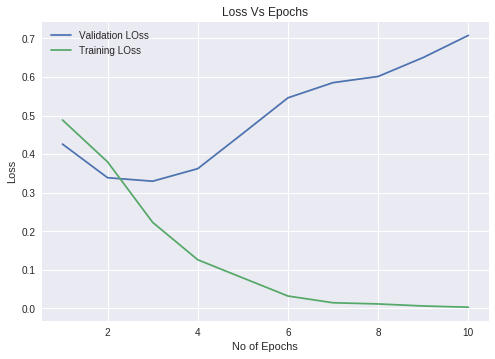

In [0]:
# Final evaluation of the model
score=model.evaluate(x_test,y_test,verbose=0)
print('Test Loss:%.4f '%score[0])
print('Test Accuracy: %.4f'%score[1])
x = list(range(1,11))
val_loss=history.history['val_loss']
tr_loss=history.history['loss']
plt.plot(x,val_loss,label="Validation LOss")
plt.plot(x,tr_loss,label="Training LOss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()
plt.show()

# Architecture-2

In [0]:
embedding_vector_length=16
model2=Sequential()
model2.add(Embedding(no_of_top_words,embedding_vector_length,input_length=max_review_length))
model2.add(LSTM(128,return_sequences=True,dropout=0.5,recurrent_dropout=0.5))
#model2.add(Dropout(0.50))
model2.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5))
#model2.add(Dropout(0.50))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 16)           80000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 128)          74240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 285,953
Trainable params: 285,953
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model2.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3958 samples, validate on 986 samples
Epoch 1/10
3958/3958 [==============================] - 83s 21ms/step - loss: 0.4757 - acc: 0.8317 - val_loss: 0.4367 - val_acc: 0.8418
Epoch 2/10
3958/3958 [==============================] - 81s 21ms/step - loss: 0.4330 - acc: 0.8391 - val_loss: 0.3988 - val_acc: 0.8418
Epoch 3/10
3958/3958 [==============================] - 81s 20ms/step - loss: 0.3257 - acc: 0.8671 - val_loss: 0.3473 - val_acc: 0.8540
Epoch 4/10
3958/3958 [==============================] - 81s 20ms/step - loss: 0.2251 - acc: 0.9101 - val_loss: 0.3465 - val_acc: 0.8621
Epoch 5/10
3958/3958 [==============================] - 82s 21ms/step - loss: 0.1763 - acc: 0.9303 - val_loss: 0.3867 - val_acc: 0.8722
Epoch 6/10
3958/3958 [==============================] - 82s 21ms/step - loss: 0.1354 - acc: 0.9464 - val_loss: 0.4391 - val_acc: 0.8631
Epoch 7/10
3958/3958 [==============================] - 81s 20ms/step - loss: 0.1020 - acc: 0.9626 - val_loss: 0.4905 - val_acc: 0.8722
E

Test Loss:0.6290 
Test Accuracy: 0.8641


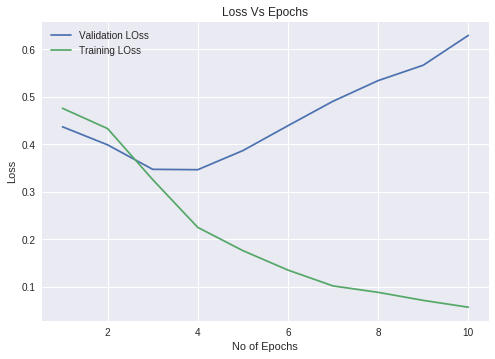

In [0]:
# Final evaluation of the model
score=model2.evaluate(x_test,y_test,verbose=0)
print('Test Loss:%.4f '%score[0])
print('Test Accuracy: %.4f'%score[1])
x = list(range(1,11))
val_loss=history.history['val_loss']
tr_loss=history.history['loss']
plt.plot(x,val_loss,label="Validation LOss")
plt.plot(x,tr_loss,label="Training LOss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()
plt.show()

**No of epoch =3**

# Architecture -3

In [0]:
embedding_vector_length=32
model=Sequential()
model.add(Embedding(no_of_top_words,embedding_vector_length,input_length=max_review_length))
model.add(LSTM(128,return_sequences=True,dropout=0.8,recurrent_dropout=0.6))
model.add(LSTM(32,dropout=0.8,recurrent_dropout=0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 32)           160000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 200, 128)          82432     
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 263,073
Trainable params: 263,073
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3958 samples, validate on 986 samples
Epoch 1/10
3958/3958 [==============================] - 53s 13ms/step - loss: 0.5035 - acc: 0.8297 - val_loss: 0.4374 - val_acc: 0.8418
Epoch 2/10
3958/3958 [==============================] - 51s 13ms/step - loss: 0.4456 - acc: 0.8391 - val_loss: 0.4382 - val_acc: 0.8418
Epoch 3/10
3958/3958 [==============================] - 51s 13ms/step - loss: 0.4446 - acc: 0.8391 - val_loss: 0.4383 - val_acc: 0.8418
Epoch 4/10
3958/3958 [==============================] - 51s 13ms/step - loss: 0.4444 - acc: 0.8388 - val_loss: 0.4369 - val_acc: 0.8418
Epoch 5/10
3958/3958 [==============================] - 51s 13ms/step - loss: 0.4433 - acc: 0.8391 - val_loss: 0.4393 - val_acc: 0.8418
Epoch 6/10
3958/3958 [==============================] - 52s 13ms/step - loss: 0.4439 - acc: 0.8391 - val_loss: 0.4366 - val_acc: 0.8418
Epoch 7/10
3958/3958 [==============================] - 51s 13ms/step - loss: 0.4413 - acc: 0.8391 - val_loss: 0.4359 - val_acc: 0.8418
E

Test Loss:0.4294 
Test Accuracy: 0.8671


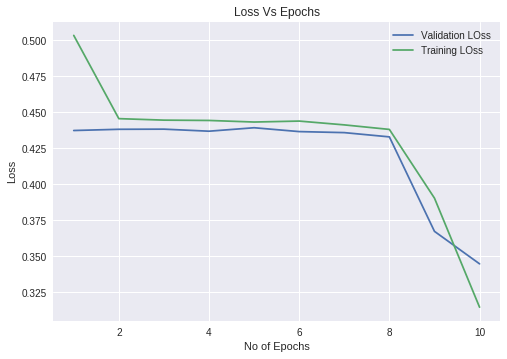

In [0]:
# Final evaluation of the model
score=model.evaluate(x_test,y_test,verbose=0)
print('Test Loss:%.4f '%score[0])
print('Test Accuracy: %.4f'%score[1])
x = list(range(1,11))
val_loss=history.history['val_loss']
tr_loss=history.history['loss']
plt.plot(x,val_loss,label="Validation LOss")
plt.plot(x,tr_loss,label="Training LOss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()
plt.show()

# Conclusion:


In [0]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=['No of LSTM','units','Accuracy']
x.add_row(['1','100','  0.8899'])
x.add_row(['2','100',' 0.8818'])
x.add_row(['2','128->32',' 0.8671'])
print(x)

+------------+---------+----------+
| No of LSTM |  units  | Accuracy |
+------------+---------+----------+
|     1      |   100   |   0.8899 |
|     2      |   100   |  0.8818  |
|     2      | 128->32 |  0.8671  |
+------------+---------+----------+


# Observations:
 1. Architecture -1 has gone underfitting
 
 2. Architecture -2 after third epoch it  started overfitting
 
  2. Architecture -3 Good Fitting